# PyTorch scaling benchmark analysis

Throughput scaling of PyTorch benchmarks on Cori Haswell with PyTorch distributed and Cray MPI.

In [1]:
import os
import re
import glob

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Utilities

In [4]:
def plot_scaling(ranks, rates, title=None, loglog=True):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Compute ideal scaling relative to lowest rank
    ideal_rates = rates[0] * ranks / ranks[0]

    # Plot throughput scaling
    ax0.plot(ranks, rates, '.-', ms=15, label='measured')
    ax0.plot(ranks, ideal_rates, '--', label='ideal')
    ax0.set_xlabel('Number of nodes')
    ax0.set_ylabel('Training throughput [samples/s]')
    if loglog:
        ax0.set_xscale('log')
        ax0.set_yscale('log')
    else:
        ax0.set_ylim(bottom=0)
    ax0.grid()
    ax0.legend(loc=0)

    # Plot the fraction of ideal scaling
    ax1.semilogx(ranks, rates / ideal_rates, '.-', ms=15)
    ax1.set_xlabel('Number of nodes')
    ax1.set_ylabel('Fraction of ideal scaling')
    ax1.grid()
    ax1.set_ylim(bottom=0)
    
    if title is not None:
        ax0.set_title(title)
        ax1.set_title(title)

    plt.tight_layout()
    return fig, ax0, ax1

## Load the results data

In [5]:
hardware = 'hsw'
version = 'v1.1.0'
pattern = '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/%s-%s-n*/results.txt' % (hardware, version)

In [6]:
results_files = glob.glob(pattern)

results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks/hsw-v1.1.0-n32/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/hsw-v1.1.0-n16/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/hsw-v1.1.0-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/hsw-v1.1.0-n4/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/hsw-v1.1.0-n8/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/hsw-v1.1.0-n2/results.txt']

In [7]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

results

,train_rate,inference_rate,ranks,hardware,version,model
0,351.620846,949.831145,32,hsw,v1.1.0,inceptionV3
1,9655.755195,24522.430880,32,hsw,v1.1.0,lstm
2,3400.655893,23009.329886,32,hsw,v1.1.0,alexnet
3,388.868050,721.859278,32,hsw,v1.1.0,resnet50
4,524.148369,1862.533880,32,hsw,v1.1.0,vgg11
5,5680.345040,13308.165343,32,hsw,v1.1.0,cnn3d
6,176.147509,457.151361,16,hsw,v1.1.0,inceptionV3
7,4959.168386,12210.325726,16,hsw,v1.1.0,lstm
8,1747.635305,11454.894958,16,hsw,v1.1.0,alexnet
9,199.680817,362.267349,16,hsw,v1.1.0,resnet50


## Training throughput scaling

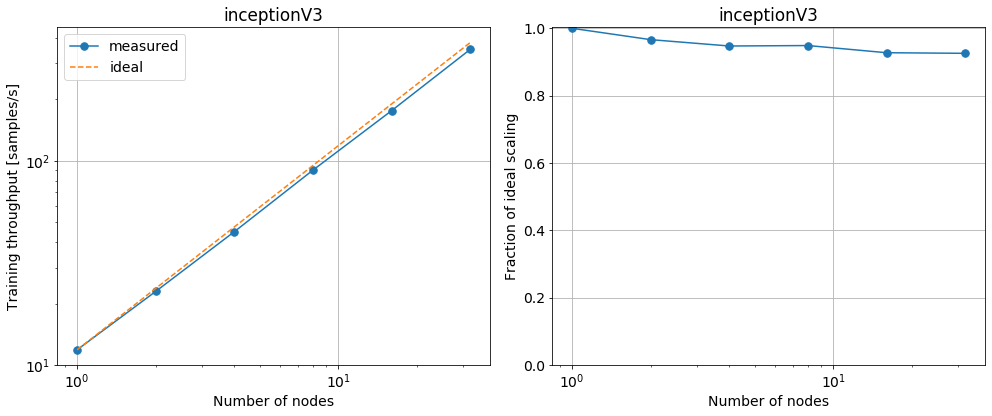

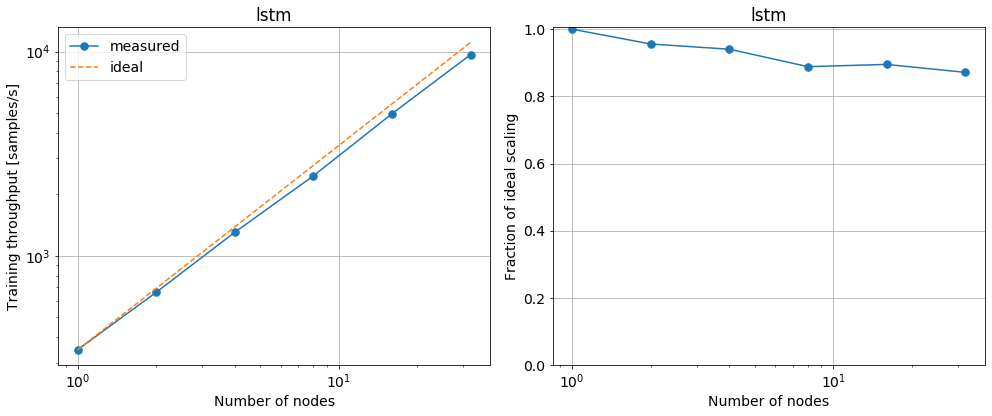

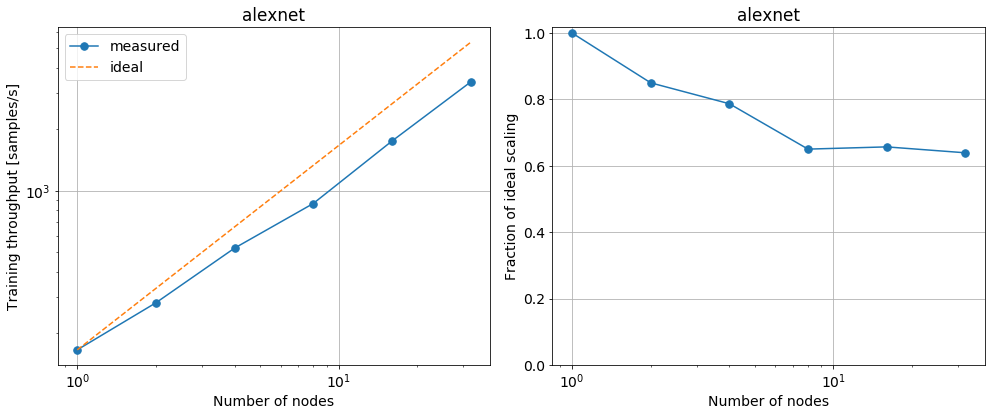

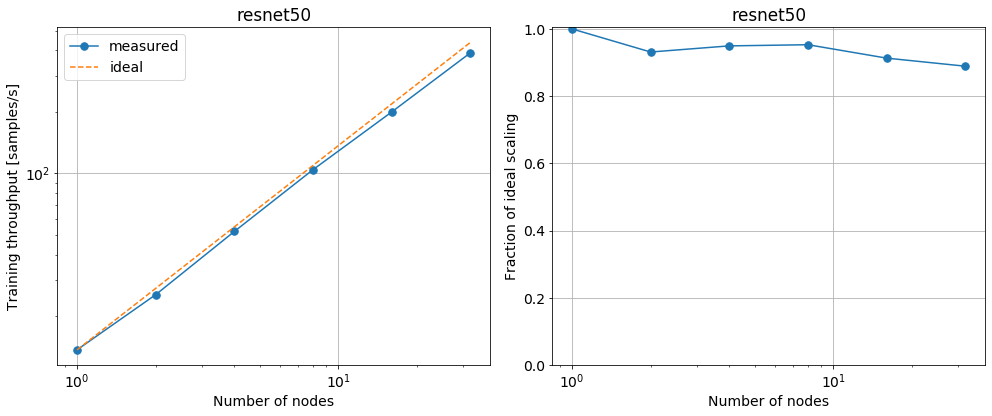

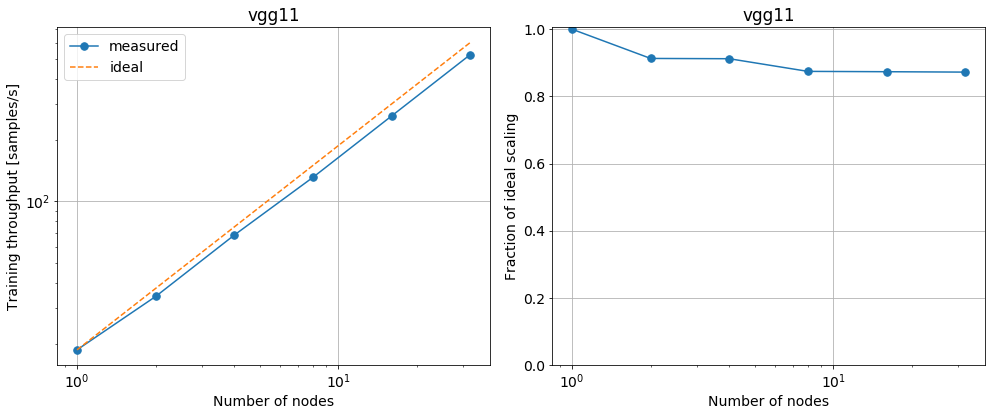

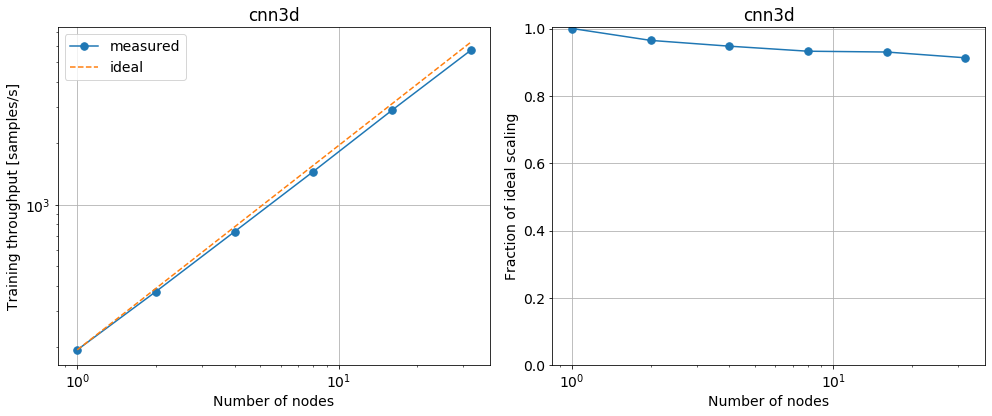

In [8]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.train_rate.values,
                                 title=model)

## Inference throughput scaling

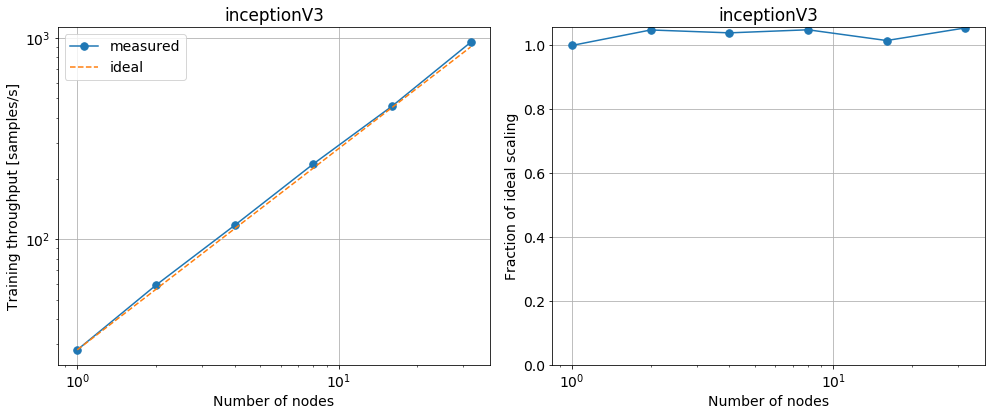

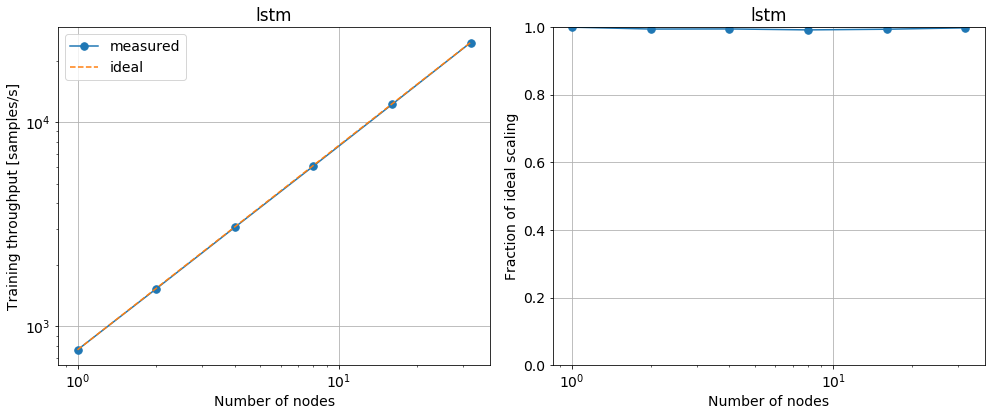

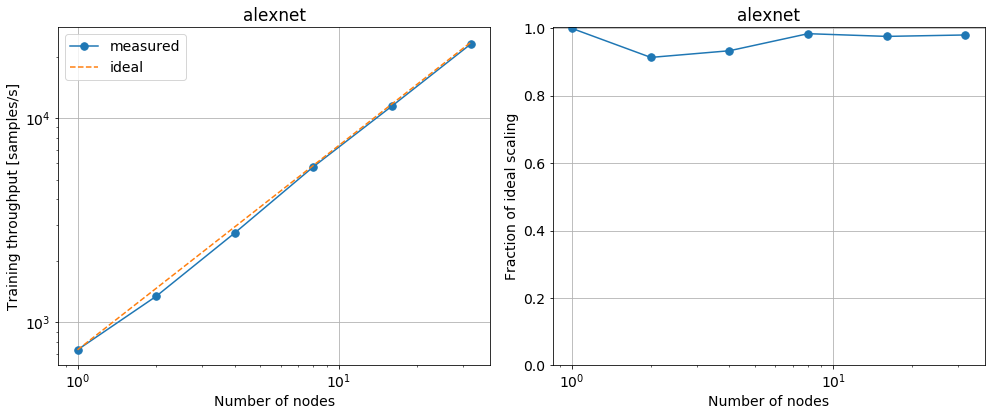

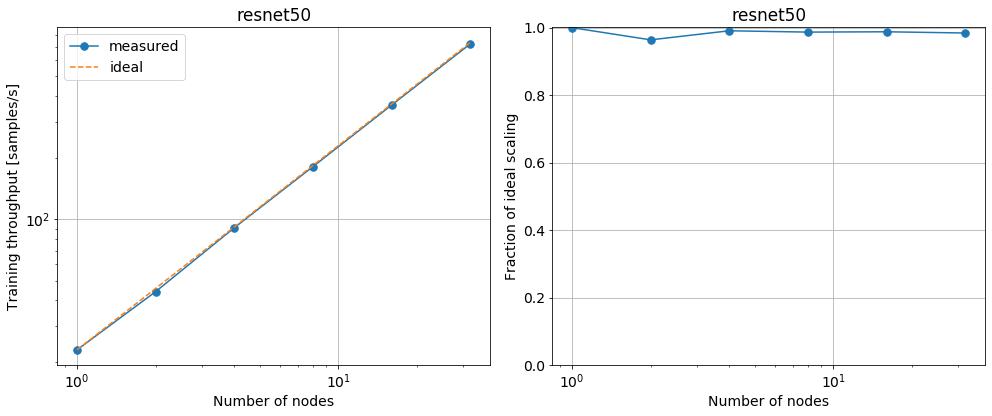

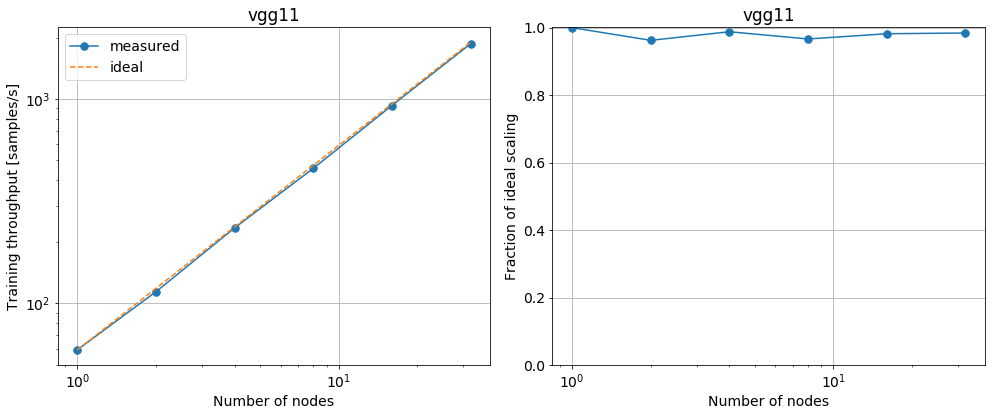

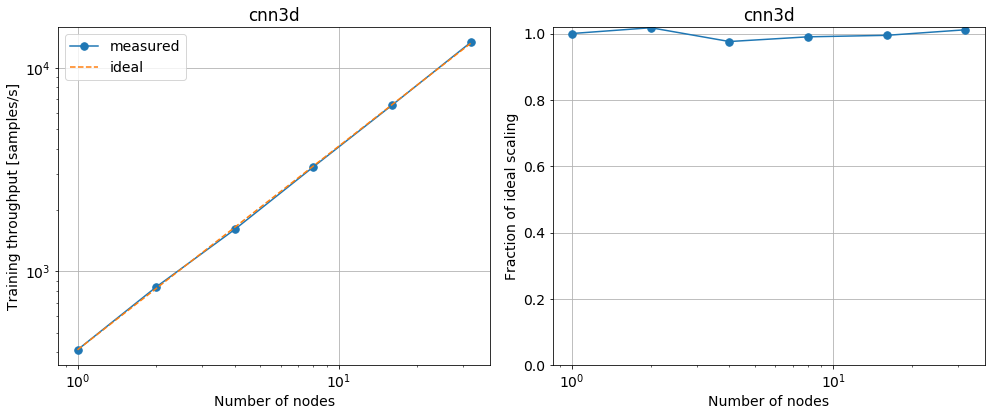

In [9]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.inference_rate.values,
                                 title=model)